In [1]:
from diff_classifier import aws as aws

import skimage.io as sio
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from skimage.filters import sobel, prewitt, scharr, gaussian, median, rank
from skimage.morphology import square, opening, closing, skeletonize, star, disk, dilation
from skimage.morphology import remove_small_objects, reconstruction, white_tophat
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import regionprops, label
from skan import csr, draw
import numpy as np
from skimage.util import pad, img_as_uint

from diff_register import im_process as imp

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [22]:
import pandas as pd

In [2]:
filename = 'P1_S1_Z1.tif'
folder = 'Tissue_Studies/01_30_19_cell_uptake/peg_noserum'
bucket = 'ccurtis.data'

In [3]:
#aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket)
image_raw = sio.imread(filename)

In [4]:
image = image_raw[0, :, :]

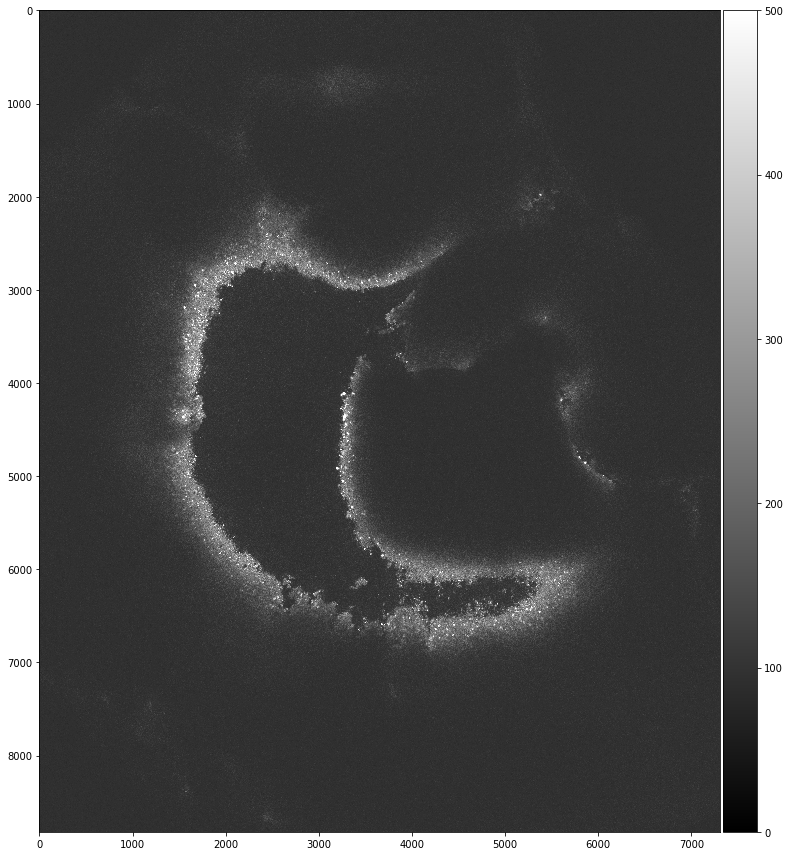

In [48]:
plt.figure(figsize=(12,12))
sio.imshow(image, cmap='gray', vmin=0, vmax=500)

In [6]:
img = image[3000:4000, 1500:2500]

In [90]:
img = image[3000:4000, 1500:2500]

filt_image = rank.mean(img, selem=star(2))
edges = prewitt(filt_image)
closeim = closing(edges, selem=star(1))
openim = img_as_uint(opening(closeim, selem=star(1)))
backg = 1*rank.mean(openim, selem=star(30))
binarim = openim > backg

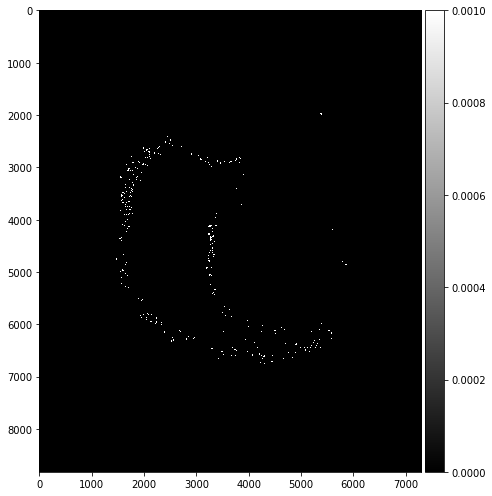

In [15]:
#image = img
def binarize_cells(image, backlevel):
    filt_image = rank.mean(image, selem=star(2))
    edges = prewitt(filt_image)
    closeim = closing(edges, selem=star(1))
    openim = img_as_uint(opening(closeim, selem=star(1)))
    backg = backlevel #1*rank.mean(openim, selem=star(30))
    binarim = openim > backg
    filled_im = binary_fill_holes(binarim)
    clean_im2 = remove_small_objects(filled_im, min_size=200)

    # # implementation of watershed
    padw = 150
    cleanpad = pad(clean_im2, ((padw, padw),), mode='constant')
    distance = ndi.distance_transform_edt(cleanpad)
    local_maxi = peak_local_max(distance, indices=False,
                                footprint=np.ones((90, 90)),
                                labels=cleanpad)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=cleanpad)
    labels = labels[padw:-padw, padw:-padw]

    label_edge = scharr(labels)
    label_edge = label_edge < 0.000000000001
    split_cells = np.logical_and(label_edge, clean_im2)
    split_cells = remove_small_objects(split_cells, min_size=200)

    plt.figure(figsize=(7,7))
    sio.imshow(split_cells, cmap='gray', vmin=0, vmax=0.001)
    
    return split_cells

In [ ]:
def filled_cells(binary_im):
    
    labelim = label(binary_im)
    intim = image_raw[1, :, :]
    props = regionprops(labelim, intensity_image=intim)
    
    areas = np.zeros(len(props))
    ints = np.zeros(len(props))

    counter = 0
    for prop in props:
        areas[counter] = prop.area
        ints[counter] = prop.mean_intensity

        counter += 1
    
    datas = {'area': areas, 'mean_intensity': ints} 
    data = pd.DataFrame(datas)
    data['total_intensity'] = data.area * data.mean_intensity
    data['p_covered5'] = data.total_intensity/(5*data.area)
    data['p_covered10'] = data.total_intensity/(10*data.area)
    data['p_covered15'] = data.total_intensity/(15*data.area)
    data['p_covered20'] = data.total_intensity/(20*data.area)
    data['p_covered40'] = data.total_intensity/(40*data.area)
    
    return data

In [29]:
labelim = label(split_cells)
intim = image_raw[1, :, :]
props = regionprops(labelim, intensity_image=intim)

In [32]:
areas = np.zeros(len(props))
ints = np.zeros(len(props))

counter = 0
for prop in props:
    areas[counter] = prop.area
    ints[counter] = prop.mean_intensity
    
    counter += 1

In [33]:
datas = {'area': areas, 'mean_intensity': ints} 

data = pd.DataFrame(datas)

In [52]:
data['total_intensity'] = data.area * data.mean_intensity
data['p_covered5'] = data.total_intensity/(5*data.area)
data['p_covered10'] = data.total_intensity/(10*data.area)
data['p_covered15'] = data.total_intensity/(15*data.area)
data['p_covered20'] = data.total_intensity/(20*data.area)
data['p_covered40'] = data.total_intensity/(40*data.area)

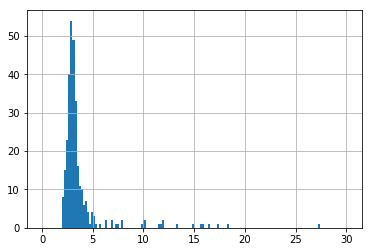

In [44]:
data['mean_intensity'].hist(bins=np.linspace(0, 30, 151))

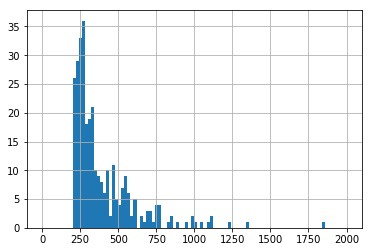

In [47]:
data['area'].hist(bins=np.linspace(0, 2000, 101))

(0, 50)

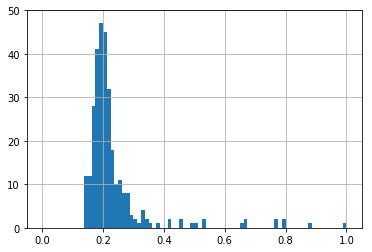

In [61]:
data['p_covered15'].hist(bins=np.linspace(0, 1, 81))
plt.ylim([0, 50])

In [62]:
filled = data.p_covered15 > 0.25
np.mean(filled)

0.20967741935483872